# Household Power Comsumption Analysis

The data used for this analysis is from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

It contains the power consumption of one household located in France with a one-minute sampling rate over almost 4 years.

The goal for this activity is to create a daily forecast of the household power consumption using a technique called LSTM, a special type of RNN that has the ability to learn long term sequences of observations. The motivation for using LSTM to forecast the daily power consumption is because of its capability to capture multiple seasonalities, in the case of the power consumption data, its yearly and weekly seasonalities.

For a quick explanation, RNNs are a type neural networks where output of the previous step is fed as input to current step. However, one of its limitations is that it has short term memory and suffers from information loss. LSTM is able to remedy this through its layers and gates. I suggest reading through this post as I feel it best summarizes how LSTM works - https://colah.github.io/posts/2015-08-Understanding-LSTMs/. The example mentioned in the blog is for text prediction but it can also be reframed for time series.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns    
plt.style.use('seaborn-colorblind')
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# load data

filepath = './power_consumption_daily.csv'

power_consumption_daily = pd.read_csv(filepath,  header=0, low_memory=False, infer_datetime_format=True, parse_dates=['datetime'], index_col='datetime')
power_consumption_daily.index = pd.DatetimeIndex(power_consumption_daily.index.values,
                               freq=power_consumption_daily.index.inferred_freq)
power_consumption_daily.head()

,Global_active_power
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


In [3]:
# scale data set and split into train v test

power_consumption = power_consumption_daily['Global_active_power'].values
power_consumption = power_consumption.reshape((-1,1))

scaler = MinMaxScaler(feature_range=(0, 1))
power_consumption_scaled = scaler.fit_transform(power_consumption)

split_percent = 0.80
split = int(split_percent*len(power_consumption_scaled))

train = power_consumption[:split]
test = power_consumption[split:]

train_scaled = power_consumption_scaled[:split]
test_scaled = power_consumption_scaled[split:]

date_train = power_consumption_daily.index[:split]
date_test = power_consumption_daily.index[split:]

#print(len(train_scaled))
#print(len(test_scaled))

In [4]:
# define look back (7 days)

look_back = 7

train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=look_back, batch_size=30)     
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=look_back, batch_size=1)

In [5]:
def model_lstm(look_back):
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(look_back,1)))
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

model=model_lstm(look_back)

history = model.fit(train_generator, epochs=100, verbose=0, validation_data=(test_generator))

In [6]:
model.evaluate_generator(test_generator)
trainPredict = model.predict_generator(train_generator)
testPredict = model.predict_generator(test_generator)

In [7]:
# invert predictions, scale values back to real consumption range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [8]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [9]:
trainY = get_y_from_generator(train_generator)
testY = get_y_from_generator(test_generator)

(1146, 1)
(282, 1)


In [10]:
# invert train/test, scale values back to real consumption range.

trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

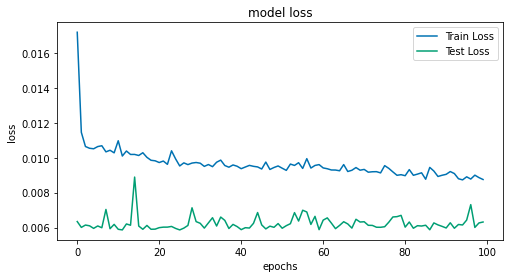

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [12]:
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

trainScore = (mean_absolute_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

testScore = (mean_absolute_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))

Train Score: 420.57 RMSE
Train Score: 309.99 MAE
Test Score: 359.55 RMSE
Test Score: 253.97 MAE


In [36]:
import plotly.graph_objects as go

train = train.reshape((-1))
test = test.reshape((-1))
prediction = testPredict.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'train data',
    marker_color='rgba(214, 40, 40, 1)'
)
trace2 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'test data',
    marker_color='rgba(0, 48, 73, 0.8)'
)
trace3 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'prediction',
    marker_color='rgba(252, 191, 73, 1)'
)
layout = go.Layout(
    title = "Daily Power Consumption",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Kilowatts"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [14]:
# create out of sample forecasts

power_consumption_scaled = power_consumption_scaled.reshape((-1))

def predict(num_prediction, model):
    prediction_list = power_consumption_scaled[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = power_consumption_daily.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 7
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
forecast_dates = pd.to_datetime(forecast_dates)
forecast_dates = pd.DatetimeIndex(forecast_dates,
                               freq=power_consumption_daily.index.inferred_freq)

In [15]:
forecast_reshape = np.reshape(forecast, (-1, 1))
forecast_inv = scaler.inverse_transform(forecast_reshape)
forecast_inv = np.reshape(forecast_inv, (-1,))
forecast_inv.shape

(8,)

In [16]:
df_2010 = power_consumption_daily.loc['2010-11-01':'2010-11-26']
actual = df_2010.values
actual = np.reshape(actual, (-1,))

In [38]:
trace1 = go.Scatter(
    x = df_2010.index,
    y = actual,
    mode = 'lines',
    name = 'Actual',
    marker_color = '#D62828'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast_inv,
    mode = 'lines',
    name = 'Forecast',
    marker_color = '#FCBF49'
)

layout = go.Layout(
    title = "Daily Power Consumption Forecast (7 days)",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Kilowatts"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

This notebook demonstrated how to use LSTM with univariate time series data. As an extension, feature extraction can also be used to improve performance. Details such as day of the week, weekday vs weekend, holidays, etc might help improve forecast values.